<a href="https://colab.research.google.com/github/vikiysr/mlprojects/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Problem Statement

i. You are provided with historical sales data for 45 retail stores located in
different regions. Each store contains a number of departments, and you are
tasked with predicting the department-wide sales for each store.
ii. In addition, the retail company runs several promotional markdown events
throughout the year. These markdowns precede prominent holidays, the four
largest of which are the Super Bowl, Labour Day, Thanksgiving, and
Christmas.
iii. Data:
1. stores.csv: This file contains anonymized information about the 45
stores, indicating the type and size of the store.
2. features.csv: Comprise of information on Markdown and
macroeconomic factors.
3. train.csv: This is the historical training data.

##Importing the Libraries and dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV


#2.Data Collection

Loading the features dataset

In [ ]:

df = pd.read_csv('/content/train.csv')

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Loading the Test data set and merging the two  dataframes

In [ ]:
test_df = pd.read_csv('/content/test.csv')
df = pd.merge(df, test_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date',"Dept"])

In [ ]:

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
stores_df = pd.read_csv('/content/stores.csv')

Merging the store dataset with our dataframe

In [ ]:
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])

Preview of updated dataframe

In [ ]:


df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


Dimensions of dataframe

In [ ]:
df.shape

(421570, 7)

Description of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 22.9+ MB


In [ ]:
df.drop_duplicates()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221


In [ ]:
df.describe()

,Store,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739
std,12.785297,30.492054,22711.183519,60980.583328
min,1.000000,1.000000,-4988.940000,34875.000000
25%,11.000000,18.000000,2079.650000,93638.000000
50%,22.000000,37.000000,7612.030000,140167.000000
75%,33.000000,74.000000,20205.852500,202505.000000
max,45.000000,99.000000,693099.360000,219622.000000


#3.Exploratory Data Analysis

Store-type wise pie chart

  Type  Store
0    A     22
1    B     17
2    C      6


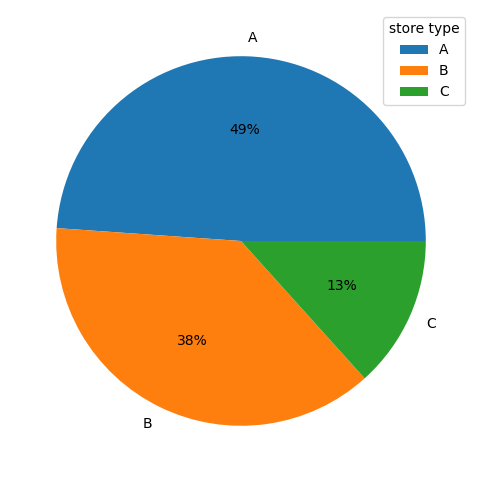

In [ ]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'],autopct = '%.0f%%')
plt.legend(title="store type")
plt.show()


In [ ]:
#Type A stores acquire half percent of the total number of stores

Size distribution of stores for each store type

<Axes: xlabel='Type', ylabel='Size'>

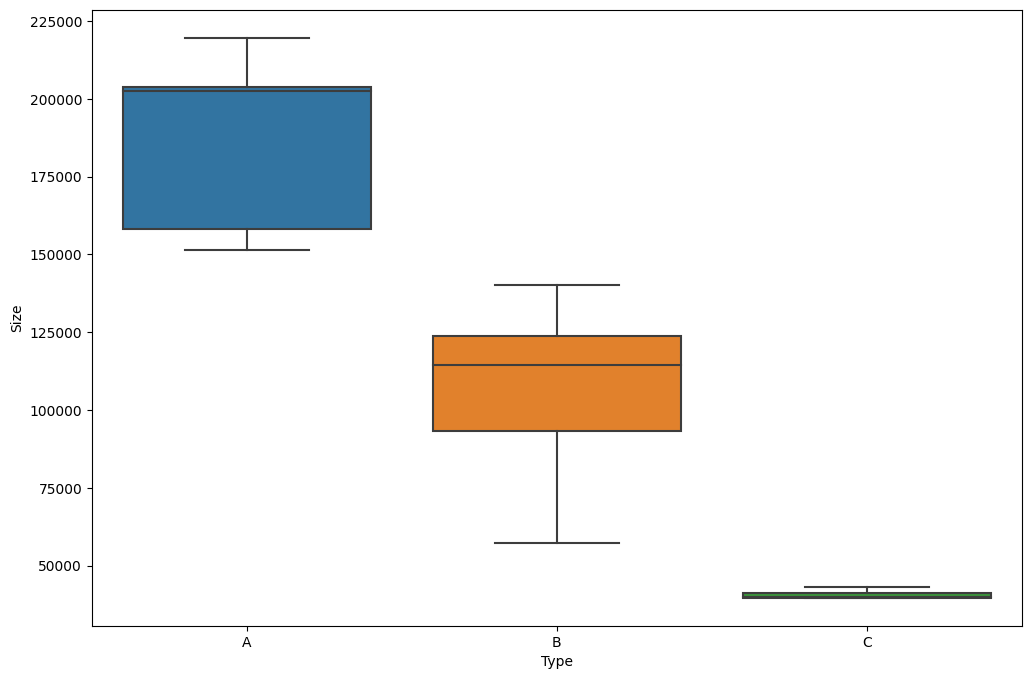

In [ ]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)

Distribution of weekly sales based on store type

<Axes: xlabel='Type', ylabel='Weekly_Sales'>

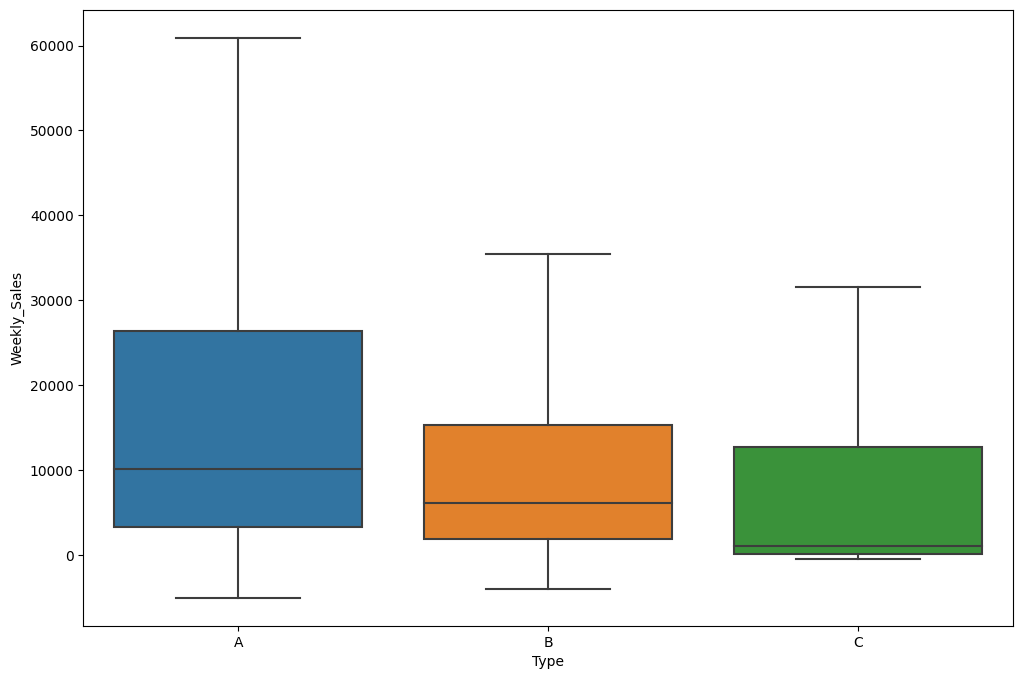

In [ ]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


Impact of holidays on weekly sales

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

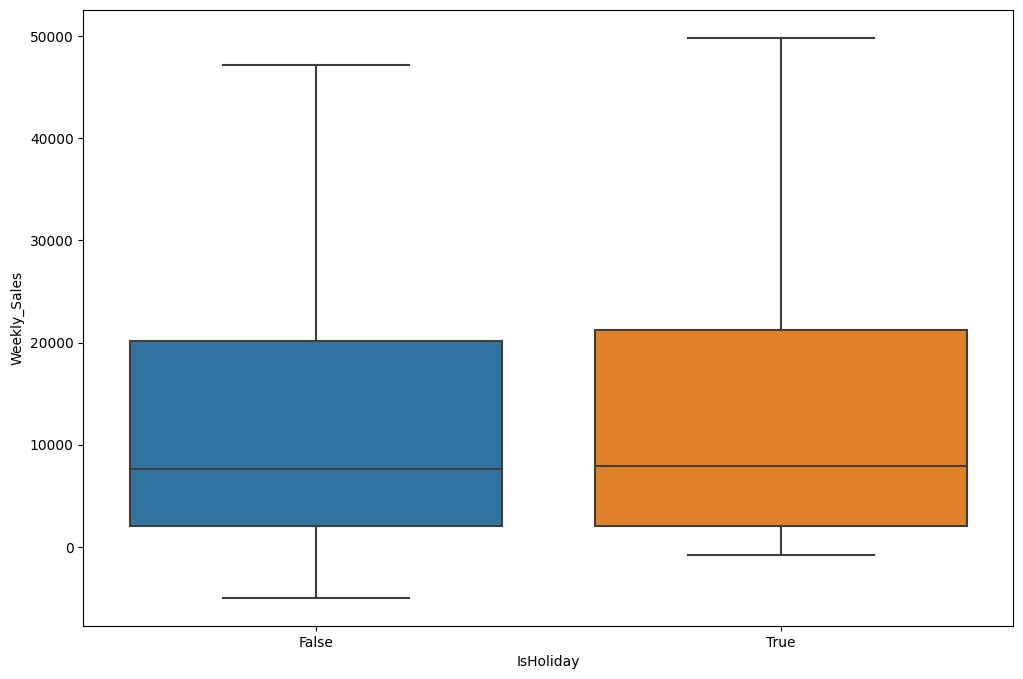

In [ ]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)


In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


#4.Data Preprocessing

In [ ]:
# create year, month, and date
df['Date'] = pd.to_datetime(df['Date'])
df['month_date'] = df['Date'].apply(lambda i : i.month)
df['day_date'] = df['Date'].apply(lambda i : i.day)
df['year_date'] = df['Date'].apply(lambda i : i.year)

One Hot Encoding of DataFrame

In [ ]:
cols_to_encode = ['Type', 'IsHoliday']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)

Preview of dataframe after One Hot Encoding

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,Size,month_date,day_date,year_date,Type_B,Type_C,IsHoliday_True
0,1,1,2010-02-05,24924.50,151315,2,5,2010,0,0,0
1,1,1,2010-02-12,46039.49,151315,2,12,2010,0,0,1
2,1,1,2010-02-19,41595.55,151315,2,19,2010,0,0,0
3,1,1,2010-02-26,19403.54,151315,2,26,2010,0,0,0
4,1,1,2010-03-05,21827.90,151315,3,5,2010,0,0,0


In [ ]:
X=df.drop(columns=["Date","Weekly_Sales"])
y=df.Weekly_Sales

Splitting the train and test data from the dataset

#5.Data Modelling 

##Finding the best model

In [ ]:
model = KNeighborsRegressor(n_neighbors = 10)
cv_score=cross_val_score(model,X,y,cv =5)
print(cv_score)
cv_score_avg=sum(cv_score)/len(cv_score)
print(cv_score_avg)


[0.21170785 0.22062857 0.26022921 0.32650126 0.33194947]
0.2702032743802311


In [ ]:
model = DecisionTreeRegressor()
cv_score=cross_val_score(model,X,y,cv =5)
print(cv_score)
cv_score_avg=sum(cv_score)/len(cv_score)
print(cv_score_avg)


[0.35483631 0.65064181 0.69365832 0.66891359 0.70404959]
0.6144199221290423


In [ ]:
model = RandomForestRegressor()
cv_score=cross_val_score(model,X,y,cv =5)
print(cv_score)
cv_score_avg=sum(cv_score)/len(cv_score)
print(cv_score_avg)

[0.41211058 0.66529036 0.7435076  0.74920343 0.7370168 ]
0.6614257549699278


In [ ]:
model = XGBRegressor()
cv_score=cross_val_score(model,X,y,cv =5)
print(cv_score)
cv_score_avg=sum(cv_score)/len(cv_score)
print(cv_score_avg)

[0.5379882  0.6996726  0.71674657 0.80393026 0.77351284]
0.7063700957645851


In [ ]:
#xgbregressor gives the maximum score

#5.Model fitting and Evaluation

In [ ]:
X=np.asarray(X)
y=np.asarray(y)

In [ ]:
scaler=StandardScaler()
X_transformed=scaler.fit_transform(X)
X=X_transformed

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
from sklearn.metrics import r2_score
model=XGBRegressor(n_estimators = 500, max_depth = 6, nthread = 4, learning_rate = 0.5, random_state = 1)
model.fit(X_train,y_train)
train_preds=model.predict(X_train)


In [ ]:
r_squared=r2_score(train_preds,y_train)
mae=mean_absolute_error(train_preds,y_train)
rmse=np.sqrt(mean_squared_error(train_preds,y_train))
print("r2Score is","= ",r_squared)
print("mae is","= ",mae)
print("rmse is ","= ",rmse)


r2Score is =  0.9825922679915042
mae is =  1608.5048208158012
rmse is  =  2954.356708679347


In [ ]:
model.fit(X_test,y_test)
test_preds=model.predict(X_test)

In [ ]:
r_squared=r2_score(test_preds,y_test)
mae=mean_absolute_error(test_preds,y_test)
rmse=np.sqrt(mean_squared_error(test_preds,y_test))
print("r2Score is","= ",r_squared)
print("mae is","= ",mae)
print("rmse is ","= ",rmse)

r2Score is =  0.9887772565662084
mae is =  1461.4995485823265
rmse is  =  2384.1427113814357


<Axes: >

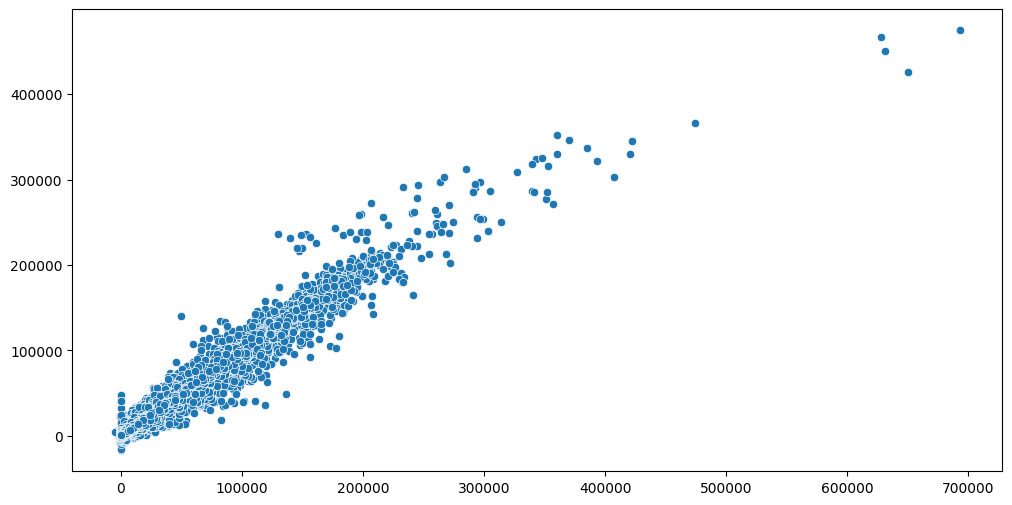

In [ ]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_train, y = train_preds)

<Axes: >

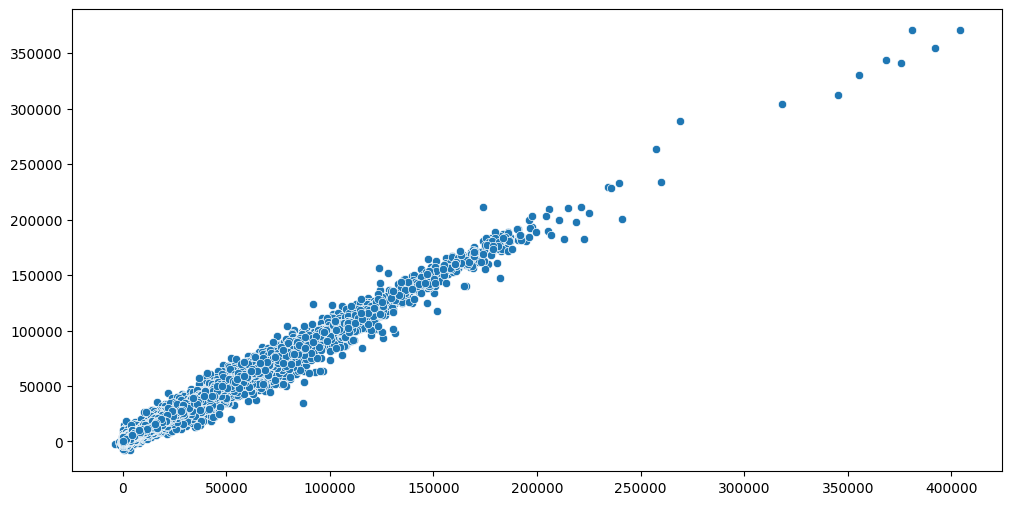

In [ ]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = test_preds)